In [1]:
import pandas as pd
import sqlalchemy
from binance.client import Client


In [2]:
#For privacy purposes 
%run ./Binance_keys.ipynb
client = Client(api_key,api_secret)

In [3]:
engine = sqlalchemy.create_engine('sqlite:///BTCUSDTstream.db')

In [4]:
df = pd.read_sql('BTCUSDT', engine)

In [5]:
df
#Live granular data printed 

,symbol,Time,Price
0,BTCUSDT,2023-02-23 10:33:05.529,24303.64
1,BTCUSDT,2023-02-23 10:33:05.529,24303.64
2,BTCUSDT,2023-02-23 10:33:05.529,24303.64
3,BTCUSDT,2023-02-23 10:33:05.540,24303.64
4,BTCUSDT,2023-02-23 10:33:05.540,24303.62
...,...,...,...
502,BTCUSDT,2023-02-23 13:59:43.220,24019.73
503,BTCUSDT,2023-02-23 13:59:43.220,24019.76
504,BTCUSDT,2023-02-23 13:59:43.220,24019.92
505,BTCUSDT,2023-02-23 13:59:43.231,24019.91


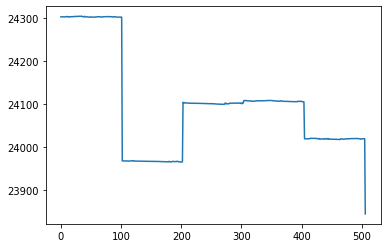

In [6]:
df.Price.plot()

In [7]:
#Strategy implementation 

"""
In this example we will use  asimple trend-following strategy using technical analysis.
TA is highly respected in the crypto market, which makes this a suitable strategy for this asset.

If the asset was rising by x % -> buy
exit when profits is above 0.15 % or loss is crossing -0.15% 
"""

'\nIn this example we will use  asimple trend-following strategy using technical analysis.\nTA is highly respected in the crypto market, which makes this a suitable strategy for this asset.\n\nIf the asset was rising by x % -> buy\nexit when profits is above 0.15 % or loss is crossing -0.15% \n'

In [8]:
def strategy (entry, lookback, qty, open_position = False):
    # entry which is the x, lookback which is the last seconds in time( time steps 1 is 1 sec) , and qty which is amount we want to trade
    while True: # requesting data from df 
        df = pd.read_sql('BTCUSDT', engine)
        lookbackperiod = df.iloc[-lookback:]
        #Cumualitve return formula 
        cumret = (lookbackperiod.Price.pct_change() +1 ).cumprod() -1
        if not open_position:
            if cumret[cumret.last_valid_index()]> entry:
                #execute order
                order = client.create_order(symbol = 'BTCUSDT', side = 'BUY', type = 'MARKET', quantity = qty)
                print(order)
                open_position = True
                break # Important to avoid opening mulitple positions 
    if open_position:
        while True:
            df = pd.read_sql('BTCUSDT', engine)
            sincebuy = df.loc[df.Time>pd.to_datetime(order['transactTime'],unit ='ms')]
            
            if len(sincebuy)> 1:
                    sincebuyret = (sincebuy.Price.pct_change() +1).cumprod() -1
                    last_entry = sincebuyret[sincebuyret.last_valid_index()]
                    if last_entry > 0.0015 or last_entry < -0.0015:
                        order = client.create_order(symbol = 'BTCUSDT', side = 'SELL', type = 'MARKET', quantity = qty)
                        print(order)
                        break


In [ ]:
strategy(0.001,60,0.001)
#Asset risen by 0.01% over last 60 seconds
